# Loading the data

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import sklearn

data_dir='./dataset/'

In [11]:
df = pd.read_csv(data_dir+'df_processed.csv')
df.drop(['id','comment_text','comment_lower','has_apostrophe','has_new_line'], axis=1, inplace=True)
df['negative_comments'] = df['label_sum'].apply(lambda x:int(x>0))
df[5:8]

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,com_processed,negative_comments
5,0,0,0,0,0,0,0,congratulations well use tools well talk,0
6,1,1,1,0,1,0,4,cocksucker piss around work,1
7,0,0,0,0,0,0,0,vandalism matt shirvington article reverted pl...,0


In [16]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def prepare_TFIDF(df_train, df_test, col):    
    vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)
    vectorizer.fit_transform(df_train[col].values)
    
    X_train = vectorizer.transform(df_train[col].values)
    X_test  = vectorizer.transform(df_test[col].values)
    
    y_train = df_train[target_columns].values
    y_test  = df_test[target_columns].values

    return X_train, X_test, y_train, y_test, vectorizer

df_train, df_test = train_test_split(df, test_size=0.2, random_state = 8848)
X_train_tf, X_test_tf, y_train_tf, y_test_tf, vectorizer= prepare_TFIDF(df_train,
                                                                        df_test,
                                                                        "com_processed")

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV


In [45]:
def mean_metrics(y_true, y_pred):
    prec, rec, fs, _ = precision_recall_fscore_support(y_true, pred)
    print ("Multilabel Classification (Mean scores)")
    print('mean precision: %.2f' % np.mean(prec))
    print('mean recall: %.2f' % np.mean(rec))
    print('mean f-score: %.2f' % np.mean(fs))
    return np.mean(prec), np.mean(rec), np.mean(fs)

def binary_metric(y_true, y_pred):
    pred_binary = np.array([1 if x > 0 else 0 for x in y_pred.sum(axis=1)])
    prec, rec, fs, _ = precision_recall_fscore_support(df_test['negative_comments'], pred_binary)
    print ("Binary Classification")
    print('precision: %.2f' % prec[1])
    print('recall: %.2f' % rec[1])
    print('f-score: %.2f' % fs[1])
    return pred_binary, prec[1], rec[1], fs[1]

In [46]:
def train_multi(model):

    clf = MultiOutputClassifier(model)
    clf.fit(X_train_tf, y_train_tf)
    pred = clf.predict(X_test_tf)
    
    prec_mean, rec_mean, fs_mean=mean_metrics(y_test_tf, pred)
    pred_bin, prec_bin, rec_bin, fs_bin=binary_metric(y_test_tf, pred)

In [47]:
model = LogisticRegression(max_iter=500)
train_multi(model)

Multilabel Classification (Mean scores)
mean precision: 0.40
mean recall: 0.63
mean f-score: 0.43
Binary Classification
precision: 0.95
recall: 0.58
f-score: 0.72


In [48]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 8848, max_depth = 20)
train_multi(model)

Multilabel Classification (Mean scores)
mean precision: 0.40
mean recall: 0.63
mean f-score: 0.43
Binary Classification
precision: 0.88
recall: 0.55
f-score: 0.68


In [49]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 8848, max_depth = 20, class_weight='balanced')
train_multi(model)

Multilabel Classification (Mean scores)
mean precision: 0.40
mean recall: 0.63
mean f-score: 0.43
Binary Classification
precision: 0.61
recall: 0.66
f-score: 0.63


In [ ]:
custom_score = make_scorer(f1_score, average='micro')

lr = LogisticRegression(class_weight='balanced')

gcv = GridSearchCV(estimator = lr,
                   param_grid = {},
                   cv = 3,
                   n_jobs = -1,
                   scoring = custom_score,
                   verbose = 0)

mlc_1 = MultiOutputClassifier(gcv)

mlc_1.fit(tfidf_train, df_train[target_columns])

In [14]:
def print_evaluation_scores(actual, pred, label):
    acc        = 100*accuracy_score(actual, pred)
    f1_micro   = 100*f1_score(actual, pred)
    avg_prec_micro = 100*average_precision_score(actual, pred)
    roc_auc    = 100*roc_auc_score(actual, pred)
    
    print (label)
    print ("\nAccuracy \t= %1.2f \nF1_micro\t= %1.2f" %(acc, f1_micro))
    print ("Avg Prec micro\t= %1.2f \nROC_AUC score\t= %1.2f" % ( avg_prec_micro, roc_auc))

In [15]:
def train_multioutput(model, X_train, y_train, X_test, y_test):
    model_multi=MultiOutputClassifier(model)
    model_multi.fit(X_train, y_train)
    pred = model_multi.predict(X_test)

    #mcm = multilabel_confusion_matrix(y_test, pred)
    fig, axL = plt.subplots(2,3, figsize=(15,10))
    for i in range(6):
        conf_matrix = confusion_matrix(y_test[:,i], pred[:,i])
        ax=axL[i//3, i%3]
        ax.set_title(target_columns[i], fontsize=14)
        sns.heatmap(conf_matrix, ax=ax, cmap='viridis', annot=True, cbar=False)
        print_evaluation_scores(y_test[:,i], pred[:,i], label=target_columns[i])

toxic

Accuracy 	= 94.37 
F1_micro	= 62.82
Avg Prec micro	= 47.34 
ROC_AUC score	= 74.34
severe_toxic

Accuracy 	= 98.95 
F1_micro	= 32.39
Avg Prec micro	= 12.09 
ROC_AUC score	= 62.54
obscene

Accuracy 	= 97.78 
F1_micro	= 76.50
Avg Prec micro	= 61.02 
ROC_AUC score	= 83.91
threat

Accuracy 	= 99.72 
F1_micro	= 29.92
Avg Prec micro	= 10.89 
ROC_AUC score	= 60.64
insult

Accuracy 	= 96.67 
F1_micro	= 62.23
Avg Prec micro	= 41.51 
ROC_AUC score	= 77.15
identity_hate

Accuracy 	= 99.11 
F1_micro	= 34.18
Avg Prec micro	= 14.14 
ROC_AUC score	= 62.44


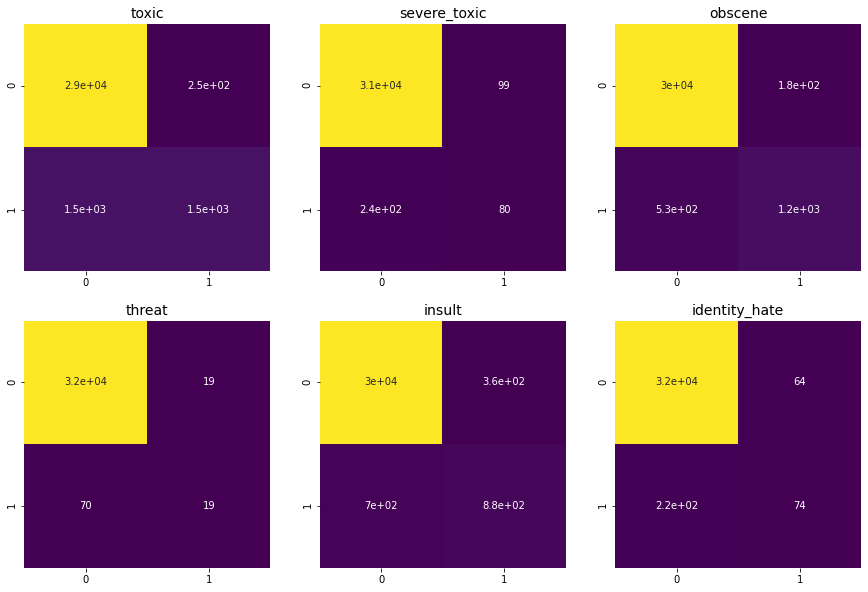

In [10]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 8848, max_depth = 20)
train_multioutput(model, X_train_tf, y_train_tf, X_test_tf, y_test_tf)

In [11]:
#model_xgb = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
#model_xgb.fit(X_train_tf, y_train_tf)

#model_xgb = OneVsRestClassifier(XGBClassifier())

#model_xgb = OneVsRestClassifier(XGBClassifier(max_depth=2, n_estimators=20, colsample_bytree=0.8,
#                          subsample=0.8, nthread=10, learning_rate=0.1))

model_xgb = OneVsRestClassifier(XGBClassifier(max_depth=2))
model_xgb.fit(X_train_tf, y_train_tf)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=2,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                         

In [8]:
y_pred_labs = model_xgb.predict(X_test_tf)
#y_pred_scores = model_xgb.decision_function(X_test_tf)

In [9]:
print_evaluation_scores(y_test_tf, y_pred_labs)

NameError: name 'print_evaluation_scores' is not defined

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score

In [7]:
def LR_model(X_train, y_train, X_test, model="LR"):
    if model=="LR":
        model = OneVsRestClassifier(LogisticRegression(penalty='l2', C=1.0, max_iter=1000))
        model.fit(X_train, y_train)

    elif model=="xgb":
        model = OneVsRestClassifier(XGBClassifier())

        model.fit(X_train, y_train)
    
    y_pred_labs = model.predict(X_test)
    y_pred_scores = model.decision_function(X_test)

    return model, y_pred_labs, y_pred_scores

In [8]:
model_LR, y_pred_labs, y_pred_scores =  LR_model(X_train_tf, y_train_tf, X_test_tf)

In [20]:
def print_evaluation_scores(y_val, predicted):
    acc        = 100*accuracy_score(y_val, predicted)
    f1_micro   = 100*f1_score(y_val, predicted, average='micro')
    avg_prec_micro = 100*average_precision_score(y_val, predicted, average='micro')
    roc_auc    = 100*roc_auc_score(y_val, predicted)
    
    print ("Accuracy \t= %1.2f \nF1_micro\t= %1.2f" %(acc, f1_micro))
    print ("Avg Prec micro\t= %1.2f \nROC_AUC score\t= %1.2f" % ( avg_prec_micro, roc_auc))

In [13]:
print ("Logistic Regression with TFIDF features")
print_evaluation_scores(y_test_tf, y_pred_labs)

Logistic Regression with TFIDF features
Accuracy 	= 92.01 
F1_micro	= 68.00
Avg Prec micro	= 50.55 
ROC_AUC score	= 68.61


In [12]:
# This is the actual out of the box algorithm
from sklearn.tree import DecisionTreeClassifier
# Make an decisiion tree object

In [13]:
#X_train_tf, X_test_tf, y_train_tf, y_test_tf,

# Make the classifier 
tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = 3)

# Fit the classifier
tree_clf.fit(X_train_tf, y_train_tf)

# Get the probabilities for the training set
y_pred_train = tree_clf.predict_proba(X_train_tf)

In [19]:
y_pred_test = tree_clf.predict_proba(X_test_tf)

In [20]:
np.array(y_pred_train).shape, np.array(y_pred_test).shape

((6, 127608, 2), (6, 31903, 2))

In [25]:
y_pred_test.reshape(6, 31903, 2)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
clf = OneVsRestClassifier(LogisticRegression())

for i in range(len(target_columns)):
    clf.fit(X_train, y_train[:,i])
    pred = clf.predict(X_test)
    print(target_columns[i], accuracy_score(y_test[:,i], pred))

In [26]:
from sklearn.multioutput import MultiOutputClassifier
mlc = MultiOutputClassifier(LogisticRegression())
mlc.fit(X_train_tf, y_train_tf)
pred = mlc.predict(X_test_tf)


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NameError: name 'multilabel_confusion_matrix' is not defined

In [27]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
mcm = multilabel_confusion_matrix(y_test_tf, pred)

Accuracy per label
toxic 0.9569006049587813
severe_toxic 0.9903143904961916
obscene 0.978654045074131
threat 0.9973043287465129
insult 0.9711939316051782
identity_hate 0.9913801209917562


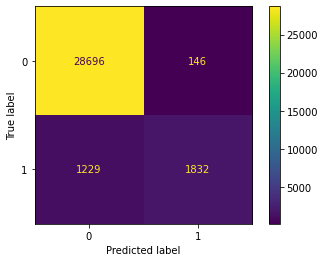

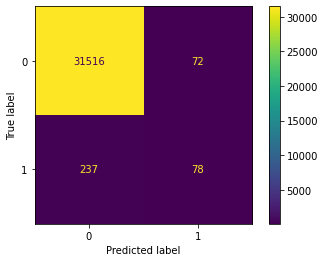

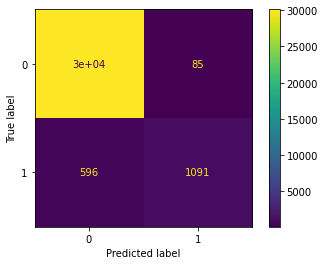

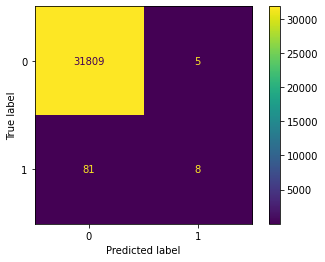

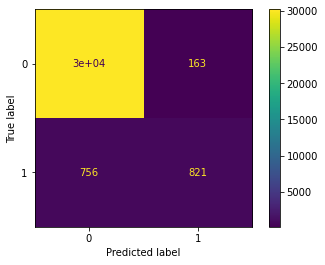

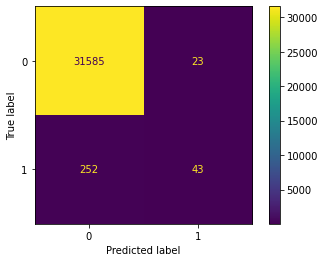

In [28]:
print('Accuracy per label')
for i in range(len(target_columns)):
    print(target_columns[i], (mcm[i,0,0]+mcm[i,1,1])/np.sum(mcm[i]))
    disp = ConfusionMatrixDisplay(mcm[i])
    disp.plot()

In [ ]:
tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = 3)

In [ ]:
clf = OneVsRestClassifier(DecisionTreeClassifier(random_state = 440, max_depth = 3))

def train(clf, x_train, y_train, x_test, y_test):
    for i in range(len(target_columns)):
        clf.fit(X_train, y_train[:,i])
        pred = clf.predict(X_test)
        print(target_columns[i], accuracy_score(y_test[:,i], pred))
        
    from sklearn.multioutput import MultiOutputClassifier
    mlc = MultiOutputClassifier(LogisticRegression())
    mlc.fit(X_train_tf, y_train_tf)
    pred = mlc.predict(X_test_tf)

                          
                          